In [1]:
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
from tqdm import tqdm
import gc
import pandas as pd
import seaborn as sns
import pickle

# aes
# import matplotlib.pyplot as plt
# from matplotlib.pyplot import rc
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size':12})
# rc('text', usetex=True)

sns.set_context("notebook", font_scale=1.25)
 
# file_path = "turl_test_2k_prompts_50.jsonl"
file_path = "turl_test_2k_prompts_50_unique.jsonl"
device = torch.device("mps")

model_name = "osunlp/TableLlama"
config = transformers.AutoConfig.from_pretrained(model_name)
orig_ctx_len = getattr(config, "max_position_embeddings", None)
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=orig_ctx_len, padding_side="left", use_fast=False)

In [2]:
# prompt formatting

PROMPT_DICT = {
    "prompt_input": (
        "Below is an instruction that describes a task, paired with an input that provides further context. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Input:\n{input_seg}\n\n### Question:\n{question}\n\n### Response:"
    ),
    "prompt_no_input": (
        "Below is an instruction that describes a task. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Response:"
    ),
}

def generate_prompt(instruction, question, input_seg=None):
    question += " Answer with just a candidate, selected from the provided referent entity candidates list, and nothing else. The selected candidate must be reported verbatim from the list provided as input. Each candidate in the list is enclosed between < and > and reports [DESC] and [TYPE] information."
    if input_seg:
        return PROMPT_DICT["prompt_input"].format(instruction=instruction, input_seg=input_seg, question=question)
    else:
        return PROMPT_DICT["prompt_no_input"].format(instruction=instruction)

In [3]:
# load questions (to be removed)

with open(file_path, "r", encoding="utf-8") as f:
    prompts = [json.loads(line) for line in f]

In [9]:
import os
import pickle
from copy import deepcopy
import zipfile

prefix = './cineca_partial/' # runs on 344 prompts with at least 1 error and 344 prompts with no error

run = 0
outlist = []

for file in os.listdir(prefix):
    if file.endswith('zip'):
        archive = zipfile.ZipFile(os.path.join(prefix, file), 'r')
        for pid, single_file in enumerate(tqdm(archive.filelist)):
            item = pickle.loads(archive.read(single_file.filename))
            item_ = deepcopy(item)
            for i, _ in enumerate(item["post_output_sequences"]):
                item_["post_output_sequences"] = item["post_output_sequences"][i]
                item_["post_output_proba_topn"] = item["post_output_proba_topn"][i]
                item_["post_output_proba_topk"] = item["post_output_proba_topk"][i]
                item_["post_output_true_entropies"] = item["post_output_true_entropies"][i] 

                item_["post_output_layers_kl"] = item["post_output_layers_kl"][i]
                # item_["post_output_layers_iou"] = item["post_output_layers_iou"][i]
                item_["transition_scores_s"] = item["transition_scores_s"][i]
                item_["transition_scores_l"] = item["transition_scores_l"][i]

                item_["run"] = run + i

                outlist.append(item_)

        run = run + i + 1 # next zip file

len(outlist)

100%|█████████████████████████████████████████| 338/338 [00:56<00:00,  5.96it/s]


3380

In [34]:
len(outlist_), len(outlist), outlist[-1]['run']

(21, 3380, 9)

In [15]:
len(item_['post_output_sequences'][0])

1818

In [16]:
p = item_
prompt = generate_prompt(p["instruction"], p["question"], p["input"])
inputs = tokenizer(prompt, return_tensors="pt")

len(inputs.input)

2037

### check output against ground truth

In [14]:
%%time

# show results

c=0
t=0
h=0

truth = []
outseq = []

for idx, p in enumerate(outlist):
    print(idx, end='\r')
    c+=1
    # in
    prompt = generate_prompt(p["instruction"], p["question"], p["input"])
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
        
    # computed
    # post_output_scores = p['post_output_scores']
    post_output_sequences = p['post_output_sequences']
    
    # bases
    baseid = len(inputs["input_ids"][0]) + 1
    endid = len(post_output_sequences[0])
    # lookout
    generated_ids = post_output_sequences
    generated_text = tokenizer.decode(generated_ids[0][baseid:endid], skip_special_tokens=True)
    # print
    # print(generated_text)
    # print(p['output'])
    # print('\n')
    #test
    
    # replacement due to tablellama "hallucinations"
    a = generated_text.replace('[DESCRIPTION]', '[DESC]').lower().strip()
    b = p['output'].lower().strip()
    # correct
    correct = False
    hallucinated = False
    if (a in b) or (b in a) or (b.startswith(a)) or (a.startswith(b)): 
        correct = True
        t+=1
    # hallucinated
    elif a not in prompt.lower().strip(): 
        h+=1
        hallucinated = True
    # incorrect
    else:
        pass
        #print(generated_text)
        #print(p['output'])
        #print('\n')
        # print(prompt)
        # print('\n')
        
    truth.append((p['run'], p['pid'], correct, hallucinated))
    outseq.append((p['run'], p['pid'], generated_text, post_output_sequences, b))

4447 3818
4447 3818
4447 3818
4447 3818
4447 3818
4447 3818
4447 3818
4447 3818
4447 3818
4447 3818
2720 2229
2720 2229
2720 2229
2720 2229
2720 2229
2720 2229
2720 2229
2720 2229
2720 2229
2720 2229
2949 2501
2949 2501
2949 2501
2949 2501
2949 2501
2949 2501
2949 2501
2949 2501
2949 2501
2949 2501
4258 3547
4258 3547
4258 3547
4258 3547
4258 3547
4258 3547
4258 3547
4258 3547
4258 3547
4258 3547
4853 4053
4853 4053
4853 4053
4853 4053
4853 4053
4853 4053
4853 4053
4853 4053
4853 4053
4853 4053
2514 2248
2514 2248
2514 2248
2514 2248
2514 2248
2514 2248
2514 2248
2514 2248
2514 2248
2514 2248
2377 1997
2377 1997
2377 1997
2377 1997
2377 1997
2377 1997
2377 1997
2377 1997
2377 1997
2377 1997
2890 2470
2890 2470
2890 2470
2890 2470
2890 2470
2890 2470
2890 2470
2890 2470
2890 2470
2890 2470
2464 2172
2464 2172
2464 2172
2464 2172
2464 2172
2464 2172
2464 2172
2464 2172
2464 2172
2464 2172
2658 2165
2658 2165
2658 2165
2658 2165
2658 2165
2658 2165
2658 2165
2658 2165
2658 2165
2658 2165


KeyboardInterrupt: 

In [47]:
len(inputs.input_ids[0]), len(post_output_sequences[0])

(4447, 3818)

In [43]:
baseid, endid

(2038, 1818)

In [42]:
len(post_output_sequences[0])

1818

In [40]:
print(post_output_sequences)
print(b)

[[2, 33501, 603, 671, 14239, 674, 19306, 476, 6911, 235269, 44600, 675, 671, 3772, 674, 6572, 4024, 4807, 235265, 15615, 476, 3590, 674, 47258, 56382, 573, 3853, 235265, 109, 6176, 36142, 235292, 108, 1596, 603, 671, 12395, 44651, 6911, 235265, 714, 6789, 604, 736, 6911, 603, 577, 3615, 573, 6410, 12395, 5512, 575, 573, 3037, 5999, 577, 573, 12395, 575, 573, 5567, 3222, 235265, 1646, 877, 614, 2764, 476, 1889, 576, 4773, 579, 26606, 235269, 675, 1853, 974, 18588, 576, 671, 12395, 1503, 235269, 1277, 5966, 578, 1277, 1916, 235265, 5651, 6475, 573, 5112, 974, 774, 573, 4773, 579, 12395, 17725, 235265, 8099, 674, 573, 16542, 2602, 235269, 16542, 4337, 578, 3037, 43770, 591, 648, 1089, 235275, 3658, 2845, 2113, 604, 22623, 573, 5112, 4773, 579, 12395, 235265, 109, 6176, 11438, 235292, 108, 235309, 97856, 235307, 235248, 235284, 235276, 235276, 235315, 235389, 235274, 235276, 173436, 3520, 633, 235265, 235288, 235265, 3891, 235265, 14405, 14432, 892, 49872, 235307, 1041, 235292, 1420, 956, 

In [36]:
# true, hallucinated, counted
t, h, c

(3380, 0, 3380)

In [17]:
# true, hallucinated, counted
t, h, c

(3702, 26, 5120)

In [18]:
truth = pd.DataFrame(truth, columns=['run', 'pid', 'correct', 'hallucinated'])

In [19]:
truth.describe(include='all')

,run,pid,correct,hallucinated
count,5120.000000,5120.000000,5120,5120
unique,NaN,NaN,2,2
top,NaN,NaN,True,False
freq,NaN,NaN,3702,5094
mean,4.500000,909.285156,NaN,NaN
std,2.872562,502.431560,NaN,NaN
min,0.000000,12.000000,NaN,NaN
25%,2.000000,474.750000,NaN,NaN
50%,4.500000,907.500000,NaN,NaN
75%,7.000000,1354.500000,NaN,NaN


<Axes: xlabel='correct', ylabel='Count'>

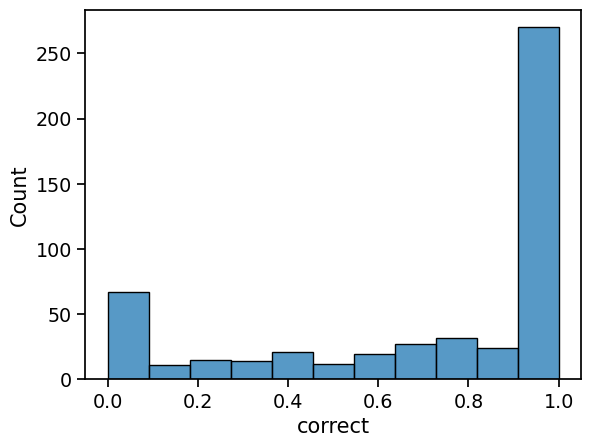

In [20]:
corec = truth.groupby('pid').correct.mean()
sns.histplot(corec, bins=corec.nunique())

<Axes: xlabel='hallucinated', ylabel='Count'>

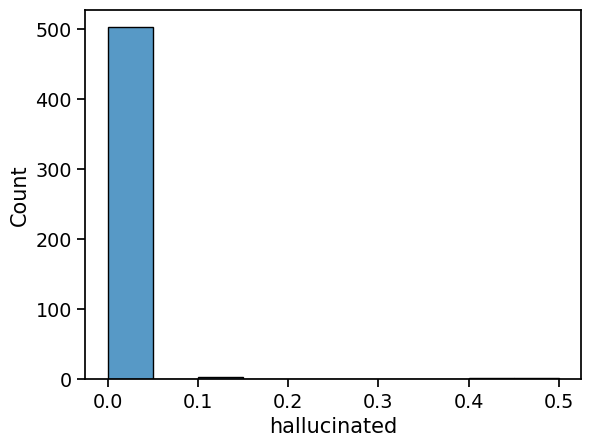

In [21]:
sns.histplot(truth.groupby('pid').hallucinated.mean())

In [22]:
truth.groupby('pid').size().value_counts()

10    512
Name: count, dtype: int64

In [23]:
truth

,run,pid,correct,hallucinated
0,0,12,False,False
1,1,12,False,False
2,2,12,False,False
3,3,12,False,False
4,4,12,False,False
...,...,...,...,...
5115,5,1794,True,False
5116,6,1794,True,False
5117,7,1794,True,False
5118,8,1794,True,False


In [24]:
accu = truth.groupby('pid').correct.mean()

In [25]:
accu[accu<1.].shape

(242,)

In [26]:
accu.value_counts()

correct
1.0    270
0.0     67
0.8     32
0.7     27
0.9     24
0.4     21
0.6     19
0.2     15
0.3     14
0.5     12
0.1     11
Name: count, dtype: int64

In [27]:
# answers
answers = pd.DataFrame(outseq, columns=['run', 'pid', 'answer', 'answer_seq', 'right_answer'])
answers.answer = answers.answer.str[:-1]

In [28]:
answers[answers.pid==112]

,run,pid,answer,answer_seq,right_answer
260,0,112,Chile [DESC] country in South America [TYPE] O...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<chile [desc] country in south america [type] ...
261,1,112,Chile [DESC] country in South America [TYPE] O...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<chile [desc] country in south america [type] ...
262,2,112,Chile [DESC] country in South America [TYPE] O...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<chile [desc] country in south america [type] ...
263,3,112,Chile [DESC] country in South America [TYPE] O...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<chile [desc] country in south america [type] ...
264,4,112,Chile [DESC] country in South America [TYPE] O...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<chile [desc] country in south america [type] ...
265,5,112,Chile [DESCRIPTION] country in South America [...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<chile [desc] country in south america [type] ...
266,6,112,Chile [DESC] country in South America [TYPE] O...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<chile [desc] country in south america [type] ...
267,7,112,Chile [DESC] country in South America [TYPE] O...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<chile [desc] country in south america [type] ...
268,8,112,Chile [DESC] country in South America [TYPE] O...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<chile [desc] country in south america [type] ...
269,9,112,Chile [DESC] country in South America [TYPE] O...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<chile [desc] country in south america [type] ...


### sequence components alignment
### (build "segments" for each sequence)

In [29]:
def is_sublist(c, m, label):
    if not c: return False
    if not m or len(c) > len(m): return False

    for i in range(len(m) - len(c) + 1):
        if m[i:i+len(c)] == c:
            return (i, i + len(c), label)
    return False

In [30]:
%%time

checks = []
alls = set()

for idx, p in enumerate(outlist):
    
    print(idx, end='\r')
    
    run = p['run']
    pid = p['pid']
    
    alls.add(p['table'])

    prompt = generate_prompt(p["instruction"], p["question"], p["input"])
    output_seq = p['post_output_sequences'][0]

    prompt_seq = tokenizer(prompt, return_tensors="pt")
    prompt_seq = prompt_seq['input_ids'][0].numpy().tolist()

    instruction_seq = tokenizer(p["instruction"], return_tensors="pt")
    instruction_seq = instruction_seq['input_ids'][0].numpy().tolist()

    question_seq = tokenizer(p["question"], return_tensors="pt")
    question_seq = question_seq['input_ids'][0].numpy().tolist()

    input_seq = tokenizer(p["input"], return_tensors="pt")
    input_seq = input_seq['input_ids'][0].numpy().tolist()

    postilla = " Answer with just a candidate, selected from the provided referent entity candidates list, and nothing else. The selected candidate must be reported verbatim from the list provided as input. Each candidate in the list is enclosed between < and > and reports [DESC] and [TYPE] information."
    postilla_seq = tokenizer(postilla, return_tensors="pt")
    postilla_seq = postilla_seq['input_ids'][0].numpy().tolist()
    
    # subseq matching
    instruction_match = is_sublist(instruction_seq[2:], output_seq, 'instruction')
    input_match = is_sublist(input_seq[2:], output_seq, 'input')
    question_match = is_sublist(question_seq[2:], output_seq, 'question') # maybe include 1?
    postilla_match = is_sublist(postilla_seq[2:], output_seq, 'postilla')
    
    # boundaries are inclusive
    checks.append((run, pid, 0, instruction_match[0], 'preamble')) # preamble
    checks.append((run, pid, instruction_match[0] + 1) + instruction_match[1:])
    checks.append((run, pid, instruction_match[1] + 1) + input_match[1:]) # sew to preceding
    checks.append((run, pid, input_match[1] + 1) + question_match[1:]) # sew to preceding
    checks.append((run, pid, postilla_match[0] + 1, len(prompt_seq) - 1, 'postilla')) # stretch postilla until the end of the prompt
    checks.append((run, pid, len(prompt_seq), len(output_seq) -1, 'generated')) # assume everything else is generated

CPU times: user 1min 12s, sys: 594 ms, total: 1min 12s
Wall time: 1min 12s


In [31]:
# check the checks (must be False)
'False' in checks

False

In [32]:
segments = pd.DataFrame(checks, columns = ['run', 'pid', 'start', 'end', 'segment'])

In [33]:
segments['seq'] = segments.segment.map({'preamble': 0, 'instruction': 1, 'input': 2, 'question': 3, 'postilla': 4, 'generated': 5})

In [34]:
segments['length'] = segments.end - segments.start

In [35]:
segments

,run,pid,start,end,segment,seq,length
0,0,12,0,40,preamble,0,40
1,0,12,41,135,instruction,1,94
2,0,12,136,762,input,2,626
3,0,12,763,2004,question,3,1241
4,0,12,2005,2069,postilla,4,64
...,...,...,...,...,...,...,...
30715,9,1794,41,135,instruction,1,94
30716,9,1794,136,719,input,2,583
30717,9,1794,720,2015,question,3,1295
30718,9,1794,2016,2080,postilla,4,64


### segment description

In [36]:
avg_seq_widths = segments.groupby(['segment', 'seq']).length.agg(['mean', 'std', 'min', 'max']).reset_index().sort_values('seq')
avg_seq_widths = avg_seq_widths.rename(columns = {'mean': 'avg_length', 
                                                  'std': 'std_length', 
                                                  'min': 'min_length',
                                                  'max': 'max_length'})
avg_seq_widths['avg_length_rel'] = avg_seq_widths['avg_length'] / avg_seq_widths['avg_length'].sum()
avg_seq_widths['avg_cumlen'] = avg_seq_widths['avg_length_rel'].cumsum() 
avg_seq_widths

,segment,seq,avg_length,std_length,min_length,max_length,avg_length_rel,avg_cumlen
4,preamble,0,40.000000,0.000000,40,40,0.015896,0.015896
2,instruction,1,94.000000,0.000000,94,94,0.037355,0.053250
1,input,2,1049.285156,669.371303,141,3643,0.416977,0.470227
5,question,3,1244.476562,308.554329,79,2328,0.494544,0.964771
3,postilla,4,64.000000,0.000000,64,64,0.025433,0.990204
0,generated,5,24.649805,5.791303,13,56,0.009796,1.000000


<Axes: xlabel='length', ylabel='Count'>

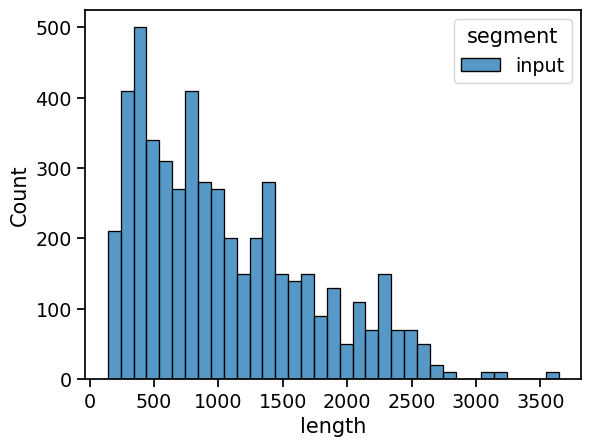

In [37]:
sns.histplot(segments[segments.segment=='input'], x='length', hue='segment', multiple='dodge', binwidth=100)

<Axes: xlabel='length'>

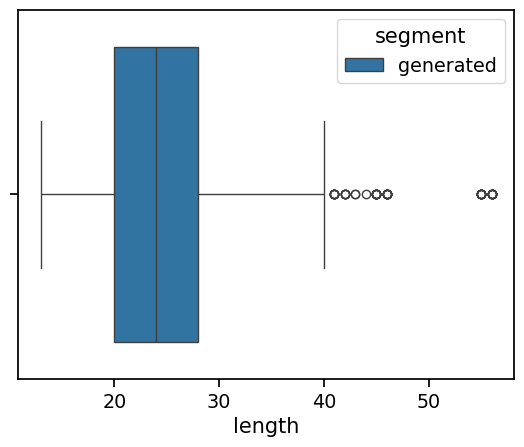

In [38]:
sns.boxplot(segments[segments.segment=='generated'], x='length', hue='segment')

<Axes: xlabel='segment', ylabel='length'>

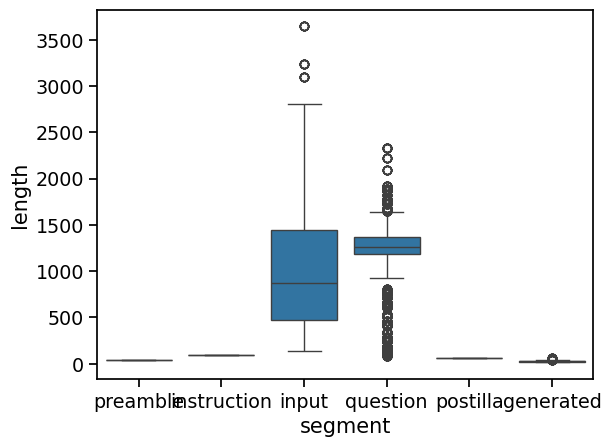

In [39]:
sns.boxplot(segments, y='length', x='segment')

In [40]:
# Define background regions [(start, end, color, label)] based on the cumulative sections spans (for the first viz above)

from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

myl = avg_seq_widths.avg_cumlen.to_list()
sections = ['preamble', 'instruction', 'input', 'question', 'postilla', 'generated']


first = (0., myl[0], palette[0], sections[0])
background_regions = [first]

for z1, z2, l, i in zip(myl, myl[1:], sections[1:], range(len(myl))):
    background_regions.append((z1,z2, palette[i+1], l))

### collect observables

In [41]:
outlist[0].keys()

dict_keys(['table', 'cell', 'instruction', 'input', 'question', 'output', 'elapsed_pre', 'pre_output_proba_topn', 'pre_output_proba_topk', 'pre_output_true_entropies', 'post_output_sequences', 'post_output_proba_topn', 'post_output_proba_topk', 'post_output_true_entropies', 'post_output_layers_kl', 'post_output_layers_iou', 'transition_scores_s', 'transition_scores_l', 'elapsed', 'pid', 'run'])

In [42]:
# outlist[0]['post_output_layers_iou'] ha dimensione n layer x m token generati
# outlist[0]['transition_scores_s'] ha dimensione m token generati

In [45]:
len(outlist[0]['post_output_layers_iou'])

32

In [46]:
len(outlist[0]['transition_scores_s']), len(outlist[0]['transition_scores_l'])

(26, 26)

In [47]:
%%time

shapes = []

# for each prompt
for i, p in enumerate(outlist):
    # for each token
    run = p['run']
    pid = p['pid']
    
    # append all forward data
    for j, pp in enumerate(p['pre_output_proba_topn']):
        shapes.append((run,pid,j,'prompt',
                           len(pp['top_n_indices']),
                           p['pre_output_true_entropies'][j],
                           max(pp['top_n_probs']),
                           None,
                           None,
                           None,
                           None))
    
    # append all generation data
    transpose_kl = list(map(list, zip(*p['post_output_layers_kl'])))
    transpose_iou = list(map(list, zip(*p['post_output_layers_iou'])))
    
    for jj, pp in enumerate(p['post_output_proba_topn']):
        shapes.append((run,pid,j+jj+1,'generated',
                           len(pp['top_n_indices']),
                           p['post_output_true_entropies'][jj],
                           max(pp['top_n_probs']),
                           p['transition_scores_s'][jj],
                           p['transition_scores_l'][jj],
                           transpose_kl[jj],
                           transpose_iou[jj]))

CPU times: user 12 s, sys: 729 ms, total: 12.7 s
Wall time: 12.8 s


In [48]:
%%time 

import pandas as pd
import numpy as np
d = pd.DataFrame(shapes, columns=['run', 'pid', 'tok', 'area', 'shape', 'true_ent', 'maxp', 'trans_s', 'trans_l', 'logitlens_kl', 'logitlens_iou'])

CPU times: user 11.2 s, sys: 624 ms, total: 11.9 s
Wall time: 11.9 s


In [49]:
d

,run,pid,tok,area,shape,true_ent,maxp,trans_s,trans_l,logitlens_kl,logitlens_iou
0,0,12,0,prompt,19111,9.367176e+00,0.012085,NaN,NaN,None,None
1,0,12,1,prompt,5595,7.157337e+00,0.097656,NaN,NaN,None,None
2,0,12,2,prompt,9,1.773033e+00,0.683594,NaN,NaN,None,None
3,0,12,3,prompt,170,4.614149e+00,0.094727,NaN,NaN,None,None
4,0,12,4,prompt,5,1.094237e+00,0.812500,NaN,NaN,None,None
...,...,...,...,...,...,...,...,...,...,...,...
12909622,9,1794,2100,generated,1,2.291777e-07,1.000000,0.0,0.000000e+00,"[6.1875, 5.03125, 6.78125, 7.28125, 9.125, 8.1...","[7.544322897019993e-05, 8.134049129656744e-05,..."
12909623,9,1794,2101,generated,1,6.453166e-07,1.000000,0.0,0.000000e+00,"[10.375, 8.75, 7.4374995, 7.3124995, 6.8749995...","[0.00011896264572924102, 9.63020030816641e-05,..."
12909624,9,1794,2102,generated,1,3.022050e-06,1.000000,0.0,-1.192093e-07,"[0.65624845, 0.15722516, 0.69140464, 1.7187482...","[0.00016608536787908985, 0.0035714285714285713..."
12909625,9,1794,2103,generated,1,1.198130e-06,1.000000,0.0,0.000000e+00,"[9.625, 8.9375, 8.6875, 8.25, 8.6875, 8.125, 8...","[8.995232526760817e-05, 0.00010240655401945725..."


In [50]:
d.logitlens_iou.str.len().unique()

array([nan, 32.])

In [51]:
# are the max index equal in observables and segments (must be True)
d.groupby(['run','pid']).tok.max().sort_values().reset_index(drop=True).equals(segments.groupby(['run','pid']).end.max().sort_values().reset_index(drop=True))

False

In [52]:
# (first 10 in generated)
d[d.area=='prompt'].groupby(['run', 'pid'], group_keys=False).apply(lambda x: x.tail(10)).describe()

,run,pid,tok,shape,true_ent,maxp,trans_s,trans_l
count,51200.000000,51200.000000,51200.000000,51200.000000,5.120000e+04,51200.000000,0.0,0.0
mean,4.500000,909.285156,2490.261719,6.098047,6.496140e-01,0.824574,NaN,NaN
std,2.872309,502.387399,709.026448,23.388213,9.252609e-01,0.239055,NaN,NaN
min,0.000000,12.000000,487.000000,1.000000,4.454147e-07,0.098145,NaN,NaN
25%,2.000000,474.750000,1943.000000,1.000000,3.187114e-04,0.671875,NaN,NaN
50%,4.500000,907.500000,2363.000000,1.000000,1.640799e-01,0.968750,NaN,NaN
75%,7.000000,1354.500000,2967.250000,2.000000,9.371238e-01,1.000000,NaN,NaN
max,9.000000,1794.000000,4153.000000,454.000000,5.037186e+00,1.000000,NaN,NaN


In [53]:
# (last 10 in prompt)
d[d.area=='generated'].groupby(['run', 'pid'], group_keys=False).apply(lambda x: x.head(10)).describe()

,run,pid,tok,shape,true_ent,maxp,trans_s,trans_l
count,51200.000000,51200.000000,51200.000000,51200.000000,5.120000e+04,51200.000000,51200.000000,5.120000e+04
mean,4.500000,909.285156,2500.261719,1.057480,4.192285e-02,0.984254,-0.027247,-3.029034e-02
std,2.872309,502.387399,709.026448,0.314367,1.644906e-01,0.070652,0.171665,1.760298e-01
min,0.000000,12.000000,497.000000,1.000000,6.587034e-10,0.228893,-4.082177,-4.203527e+00
25%,2.000000,474.750000,1953.000000,1.000000,5.905422e-07,0.999941,0.000000,-5.927506e-05
50%,4.500000,907.500000,2373.000000,1.000000,9.364182e-06,0.999999,0.000000,-4.768370e-07
75%,7.000000,1354.500000,2977.250000,1.000000,6.992200e-04,1.000000,0.000000,0.000000e+00
max,9.000000,1794.000000,4163.000000,10.000000,2.279310e+00,1.000000,0.000000,0.000000e+00


In [54]:
%%time

# attach sections

m = d.merge(segments, on=['run','pid'], how='left')
m = m[(m.start <= m.tok) & (m.tok <= m.end)]

CPU times: user 8.94 s, sys: 4.17 s, total: 13.1 s
Wall time: 14.6 s


In [55]:
m

,run,pid,tok,area,shape,true_ent,maxp,trans_s,trans_l,logitlens_kl,logitlens_iou,start,end,segment,seq,length
0,0,12,0,prompt,19111,9.367176e+00,0.012085,NaN,NaN,None,None,0,40,preamble,0,40
6,0,12,1,prompt,5595,7.157337e+00,0.097656,NaN,NaN,None,None,0,40,preamble,0,40
12,0,12,2,prompt,9,1.773033e+00,0.683594,NaN,NaN,None,None,0,40,preamble,0,40
18,0,12,3,prompt,170,4.614149e+00,0.094727,NaN,NaN,None,None,0,40,preamble,0,40
24,0,12,4,prompt,5,1.094237e+00,0.812500,NaN,NaN,None,None,0,40,preamble,0,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77457737,9,1794,2100,generated,1,2.291777e-07,1.000000,0.0,0.000000e+00,"[6.1875, 5.03125, 6.78125, 7.28125, 9.125, 8.1...","[7.544322897019993e-05, 8.134049129656744e-05,...",2081,2105,generated,5,24
77457743,9,1794,2101,generated,1,6.453166e-07,1.000000,0.0,0.000000e+00,"[10.375, 8.75, 7.4374995, 7.3124995, 6.8749995...","[0.00011896264572924102, 9.63020030816641e-05,...",2081,2105,generated,5,24
77457749,9,1794,2102,generated,1,3.022050e-06,1.000000,0.0,-1.192093e-07,"[0.65624845, 0.15722516, 0.69140464, 1.7187482...","[0.00016608536787908985, 0.0035714285714285713...",2081,2105,generated,5,24
77457755,9,1794,2103,generated,1,1.198130e-06,1.000000,0.0,0.000000e+00,"[9.625, 8.9375, 8.6875, 8.25, 8.6875, 8.125, 8...","[8.995232526760817e-05, 0.00010240655401945725...",2081,2105,generated,5,24


In [56]:
# did we merge all the tokens to their segments (must be True)
d[['run', 'pid', 'tok']].sort_values(['run', 'pid', 'tok']).reset_index(drop=True).equals(m[['run', 'pid', 'tok']].sort_values(['run', 'pid', 'tok']).reset_index(drop=True))

True

In [57]:
# check that all the six sections are present in each prompt (must be True)
m.drop_duplicates(['pid', 'segment']).shape[0] == m.pid.nunique() * 6

True

In [58]:
# token position normalization

# normalized per section, offset by section sequence number
m['tok_rel_segm'] = m.tok / m.end

# normalized per section, each section same width
m['tok_rel_segm_abs'] = m.seq + ((m.tok - m.start) / (m.end - m.start))

# token relative to section start
m['tokzero'] = m['tok'] - m['start']

# token relative to section end (negative)
m['tokzero_end'] = m['tok'] - m['end'] - 1

### check variances

In [59]:
m[m.segment=='preamble'].drop_duplicates('pid', keep='first')['true_ent'].var()

0.0

In [60]:
m[m.segment=='preamble'].drop_duplicates('pid', keep='last')['true_ent'].var()

0.0

In [61]:
m[m.segment=='instruction'].drop_duplicates('pid', keep='first')['true_ent'].var()

0.0

In [62]:
m[m.segment=='instruction'].drop_duplicates('pid', keep='last')['true_ent'].var()

0.0

In [63]:
m[m.segment=='question'].drop_duplicates('pid', keep='first')['true_ent'].var()

0.29755592

In [64]:
m[m.segment=='question'].drop_duplicates('pid', keep='last')['true_ent'].var()

0.034044325

In [65]:
m[m.segment=='generated'].drop_duplicates('pid', keep='first')['true_ent'].var()

0.08451274

In [66]:
m[m.segment=='generated'].drop_duplicates('pid', keep='last')['true_ent'].var()

6.2871064e-10

In [67]:
if True:
    myoutdict = {'truth': truth, 'segments': segments, 'm': m, 'answers': answers}

    import pickle

    with open('preprocessed.pickle', 'wb') as handle:
        pickle.dump(myoutdict, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [68]:
!ls -larth | grep preprocessed

-rw-r--r--   1 bono  staff    16M Feb 20 20:07 tablellama.preprocessed.pickle
-rw-r--r--   1 bono  staff   1.3G Mar 12 11:49 preprocessed.pickle.old
-rw-r--r--@  1 bono  staff   1.8G Mar 27 07:34 preprocessed.pickle


## Load preprocessed

In [69]:
with open('preprocessed.pickle', 'rb') as handle:
    mydict = pickle.load(handle)
    
truth = mydict['truth']
segments = mydict['segments']
m = mydict['m']
answers = mydict['answers']

In [70]:
m

,run,pid,tok,area,shape,true_ent,maxp,trans_s,trans_l,logitlens_kl,logitlens_iou,start,end,segment,seq,length,tok_rel_segm,tok_rel_segm_abs,tokzero,tokzero_end
0,0,12,0,prompt,19111,9.367176e+00,0.012085,NaN,NaN,None,None,0,40,preamble,0,40,0.000000,0.000000,0,-41
6,0,12,1,prompt,5595,7.157337e+00,0.097656,NaN,NaN,None,None,0,40,preamble,0,40,0.025000,0.025000,1,-40
12,0,12,2,prompt,9,1.773033e+00,0.683594,NaN,NaN,None,None,0,40,preamble,0,40,0.050000,0.050000,2,-39
18,0,12,3,prompt,170,4.614149e+00,0.094727,NaN,NaN,None,None,0,40,preamble,0,40,0.075000,0.075000,3,-38
24,0,12,4,prompt,5,1.094237e+00,0.812500,NaN,NaN,None,None,0,40,preamble,0,40,0.100000,0.100000,4,-37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77457737,9,1794,2100,generated,1,2.291777e-07,1.000000,0.0,0.000000e+00,"[6.1875, 5.03125, 6.78125, 7.28125, 9.125, 8.1...","[7.544322897019993e-05, 8.134049129656744e-05,...",2081,2105,generated,5,24,0.997625,5.791667,19,-6
77457743,9,1794,2101,generated,1,6.453166e-07,1.000000,0.0,0.000000e+00,"[10.375, 8.75, 7.4374995, 7.3124995, 6.8749995...","[0.00011896264572924102, 9.63020030816641e-05,...",2081,2105,generated,5,24,0.998100,5.833333,20,-5
77457749,9,1794,2102,generated,1,3.022050e-06,1.000000,0.0,-1.192093e-07,"[0.65624845, 0.15722516, 0.69140464, 1.7187482...","[0.00016608536787908985, 0.0035714285714285713...",2081,2105,generated,5,24,0.998575,5.875000,21,-4
77457755,9,1794,2103,generated,1,1.198130e-06,1.000000,0.0,0.000000e+00,"[9.625, 8.9375, 8.6875, 8.25, 8.6875, 8.125, 8...","[8.995232526760817e-05, 0.00010240655401945725...",2081,2105,generated,5,24,0.999050,5.916667,22,-3


In [71]:
m.area.unique()

array(['prompt', 'generated'], dtype=object)

In [72]:
mm = m.copy()

### single run plots

In [73]:
m = mm[mm.run==0].copy()

In [74]:
NUM_BINS = 100

99


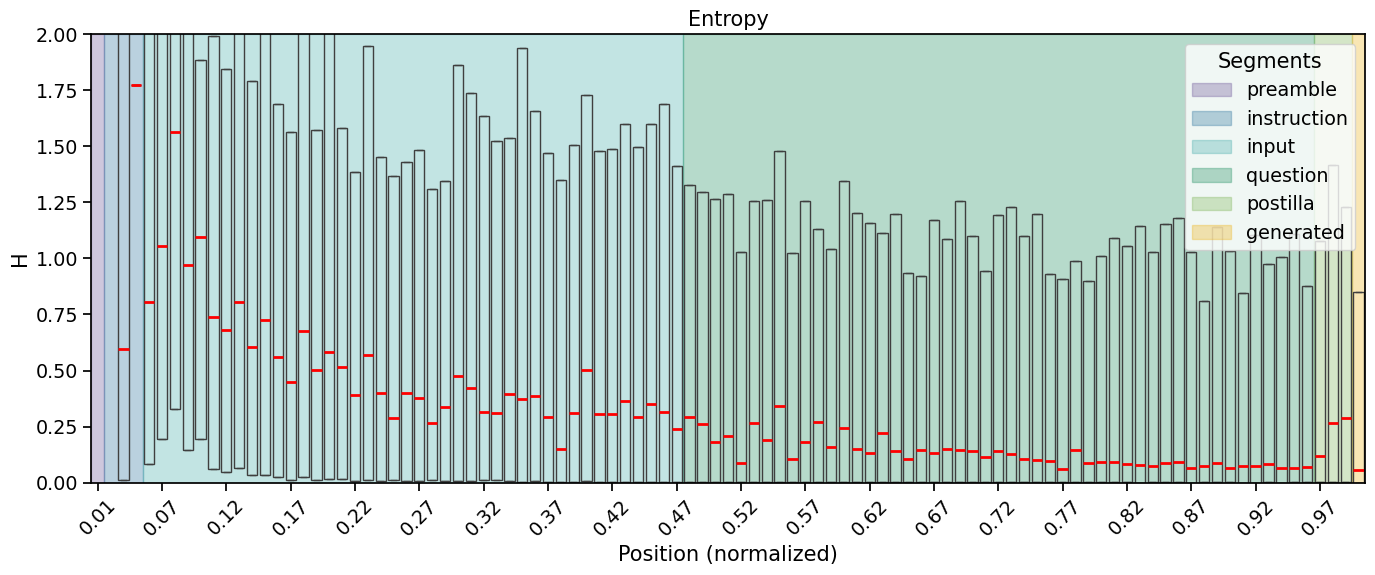

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()

m['tok_bin'] = pd.cut(m['tok_rel_segm'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))

patches = []
for start, end, color, label in background_regions:
    start_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > start ][0]
    end_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > end ]
    if not end_bin: end_bin = len(bin_mapping) - 1 
    else: end_bin = end_bin[0] - 1
    ax.axvspan(bin_mapping[bks[start_bin]]-0.5, bin_mapping[bks[end_bin]]+0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[25, 75],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")
ax.set(ylim=(0, 2))

ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [76]:
ax.figure.savefig('./pdf/entropy_per_segment.pdf',dpi=600, bbox_inches="tight")

100


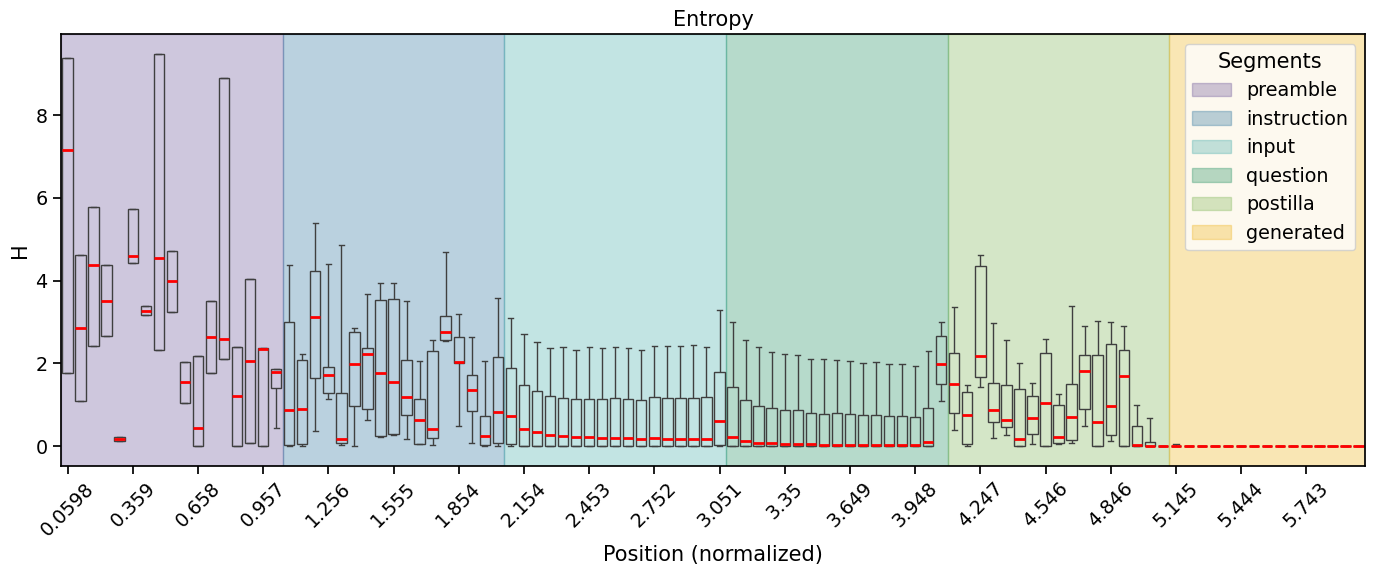

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m['tok_bin'] = pd.cut(m['tok_rel_segm_abs'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))


patches = []
c = -0.5
delta = int(len(bks)/6)+1
for start, end, color, label in background_regions:
    ax.axvspan(c, c+delta, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 
    c += delta

df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [78]:
ax.figure.savefig('./pdf/entropy_per_segment_unnorm.pdf',dpi=600, bbox_inches="tight")

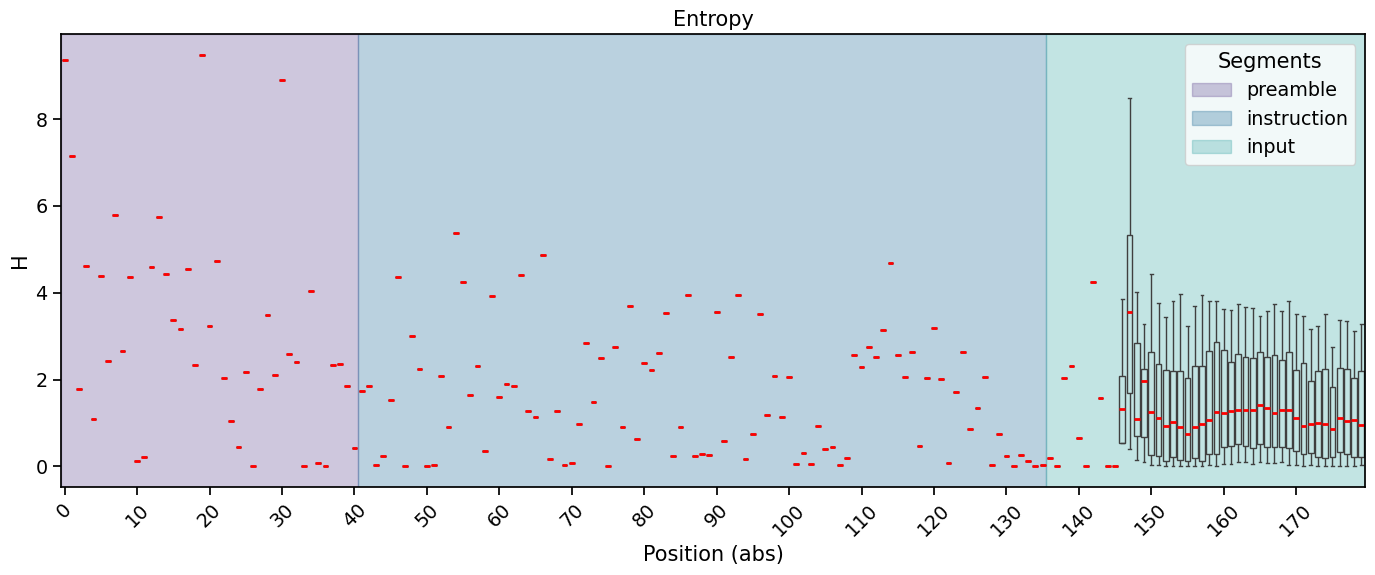

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = m[m.tok<180]

background_regions_ = [
    (0.0, 40.0, palette[0], 'preamble'),
    (41.0, 135.0, palette[1], 'instruction'),
    (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start -0.5, end + 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tok", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (abs)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [80]:
segments.segment.unique()

array(['preamble', 'instruction', 'input', 'question', 'postilla',
       'generated'], dtype=object)

In [81]:
ax.figure.savefig('./pdf/entropy_beginning.pdf',dpi=600, bbox_inches="tight")

### absolute boundary between input and question

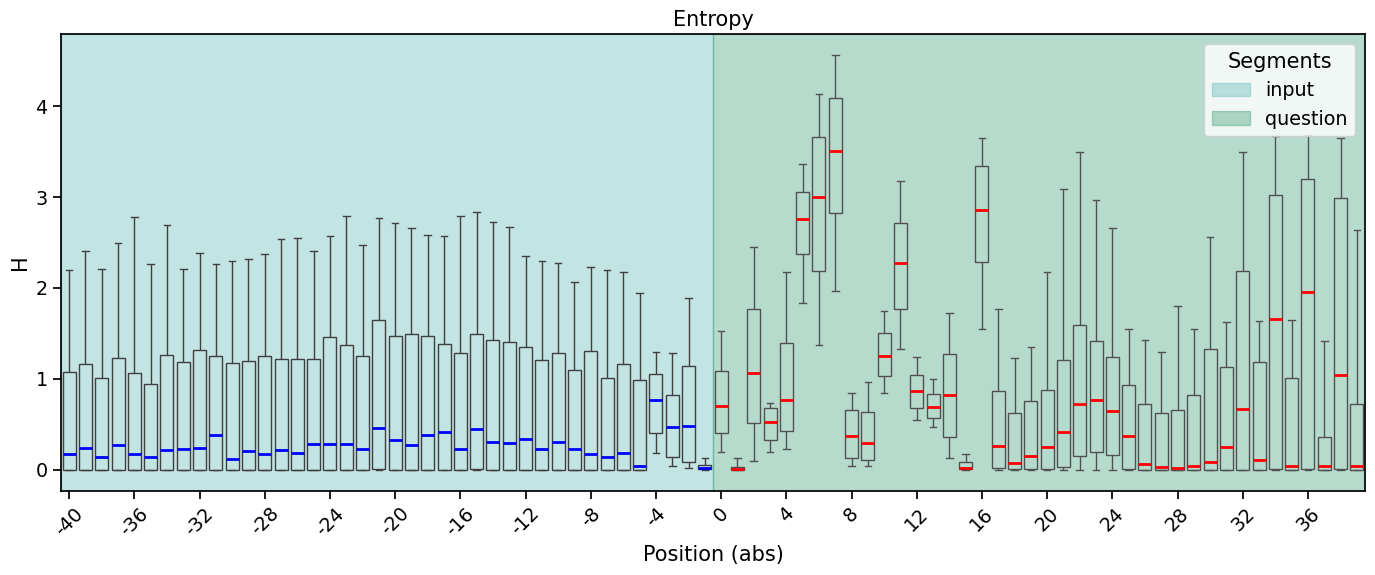

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 40
m_ = m[ ((m.segment == 'input') & (m.tokzero_end >= -delta))] #  

background_regions_ = [
    (0, delta, palette[2], 'input'),
    (delta, 2*delta, palette[3], 'question'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'blue', 'linewidth': 2},
    ax = ax
)

m_ = m[ (m.segment == 'question') & (m.tokzero < delta) ]

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (abs)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [83]:
ax.figure.savefig('./pdf/entropy_boundary_input_and_question.pdf',dpi=600, bbox_inches="tight")

### absolute boundary between  question and postilla

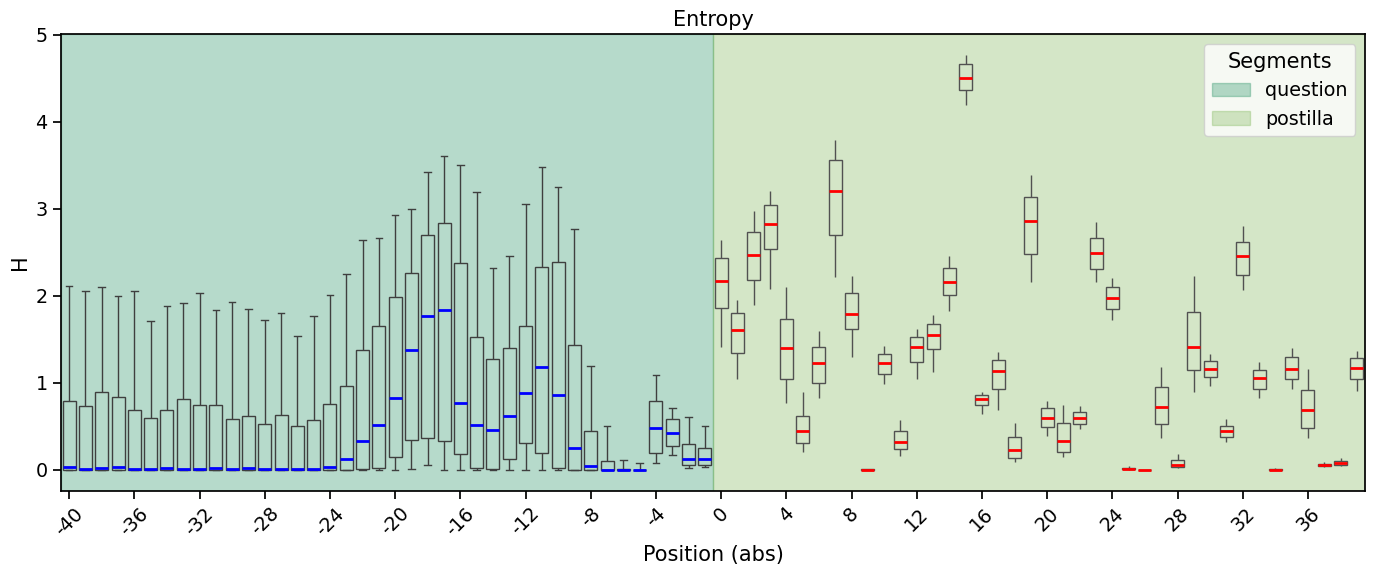

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 40
m_ = m[ ((m.segment == 'question') & (m.tokzero_end >= -delta))] #  

postillalen = m[m.segment=='postilla'].tokzero.max()

background_regions_ = [
    (0, delta, palette[3], 'question'),
    (delta, 2 * delta + 1, palette[4], 'postilla'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'blue', 'linewidth': 2},
    ax = ax
)

m_ = m[ (m.segment == 'postilla') & (m.tokzero < delta) ]

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=False,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)


# plt.yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (abs)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [85]:
ax.figure.savefig('./pdf/entropy_boundary_question_and_postilla.pdf',dpi=600, bbox_inches="tight")

### boundary between postilla and generated

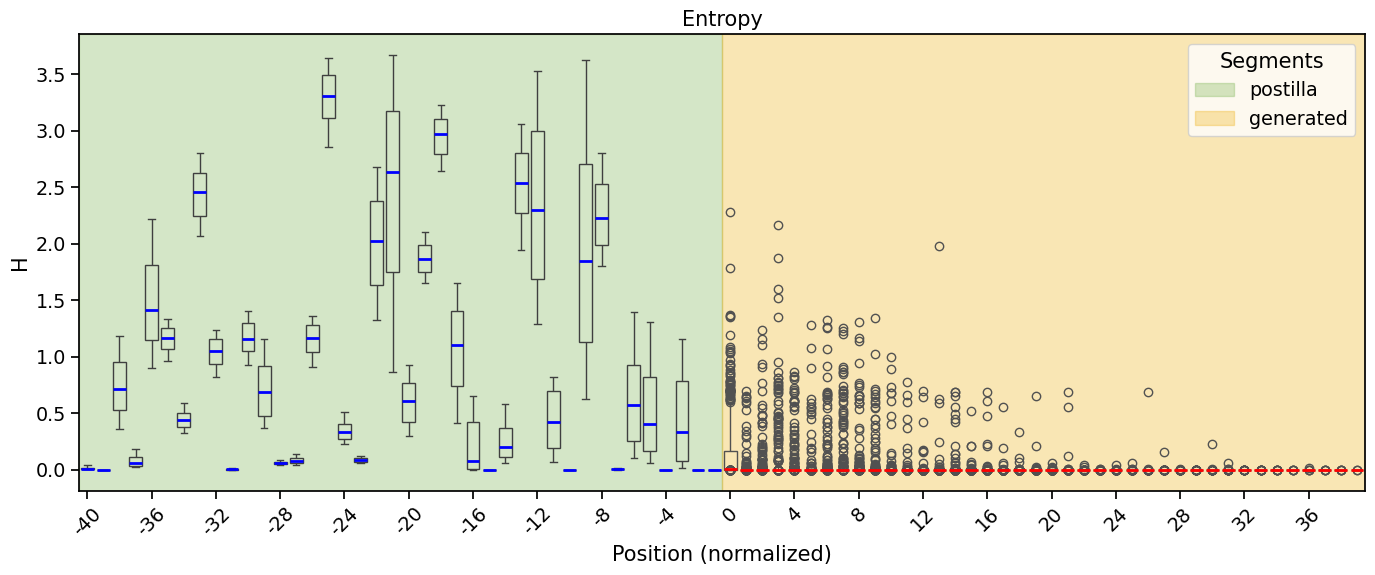

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 40
m_ = m[ ((m.segment == 'postilla') & (m.tokzero_end >= -delta))] #  

background_regions_ = [
    (0, delta, palette[4], 'postilla'),
    (delta, 2 * delta + 1, palette[5], 'generated'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'blue', 'linewidth': 2},
    ax = ax
)

m_ = m[ (m.segment == 'generated') & (m.tokzero < delta) ]

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)


# plt.yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [87]:
ax.figure.savefig('./pdf/entropy_boundary_postilla_and_generated.pdf',dpi=600, bbox_inches="tight")

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_49785/2463233701.py:30: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_49785/2463233701.py:48: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(


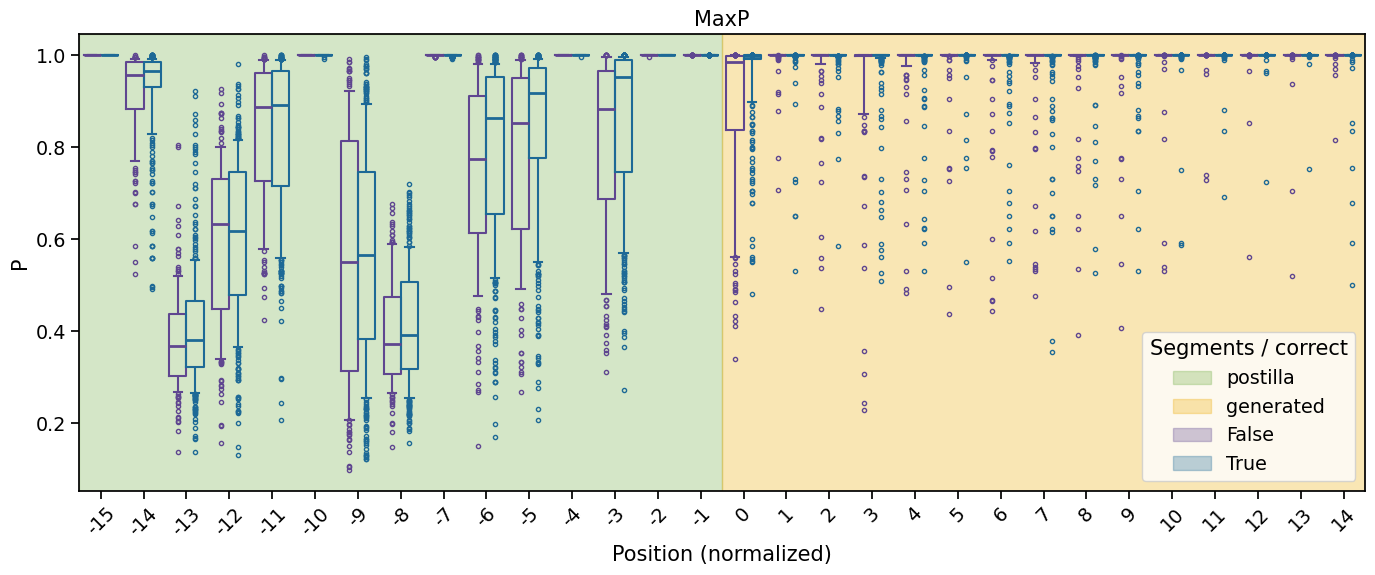

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 15
m_ = m[ ((m.segment == 'postilla') & (m.tokzero_end >= -delta))] #  
m_ = m_.merge(truth, on=['run', 'pid'])


background_regions_ = [
    (0, delta, palette[4], 'postilla'),
    (delta, 2 * delta + 1, palette[5], 'generated'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="maxp", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    medianprops={'linewidth': 2},
    hue='correct',
    fill=False,
    palette=palette,
    flierprops = {'marker':'o', 'markersize':3},
    ax = ax
)

m_ = m[ (m.segment == 'generated') & (m.tokzero < delta) ]
m_ = m_.merge(truth, on=['run', 'pid'])

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="maxp", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    # boxprops={'facecolor': 'none'},
    # medianprops={'color': 'red', 'linewidth': 2},
    medianprops={'linewidth': 2},
    hue='correct',
    fill=False,
    palette=palette,
    flierprops = {'marker':'o', 'markersize':3},
    ax = ax
)

patches.append(mpatches.Patch(color=palette[0], alpha=0.3, label='False'))
patches.append(mpatches.Patch(color=palette[1], alpha=0.3, label='True'))


#plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("P")
plt.title("MaxP")

ax.legend(handles=patches, title="Segments / correct", loc="lower right")

plt.tight_layout()

plt.show()

In [89]:
ax.figure.savefig('./pdf/entropy_boundary_postilla_and_generated_grouped_by_correct.pdf',dpi=600, bbox_inches="tight")

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_49785/2499406647.py:30: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_49785/2499406647.py:48: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(


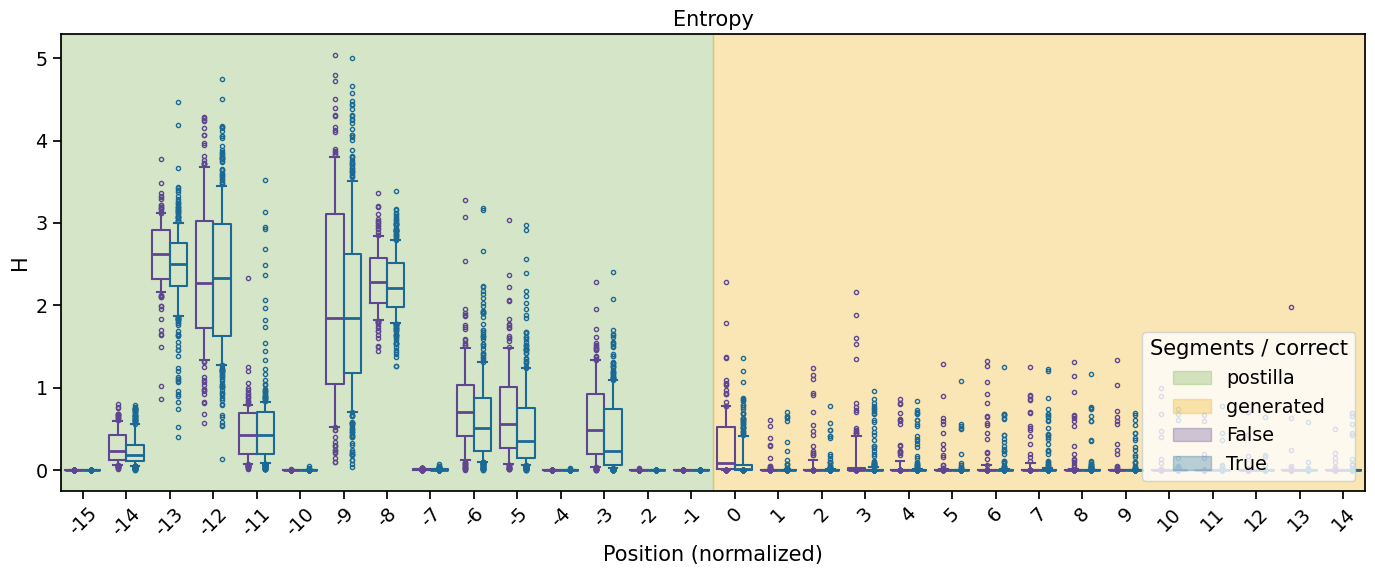

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 15
m_ = m[ ((m.segment == 'postilla') & (m.tokzero_end >= -delta))] #  
m_ = m_.merge(truth, on=['run', 'pid'])


background_regions_ = [
    (0, delta, palette[4], 'postilla'),
    (delta, 2 * delta + 1, palette[5], 'generated'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="true_ent", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    medianprops={'linewidth': 2},
    hue='correct',
    fill=False,
    palette=palette,
    flierprops = {'marker':'o', 'markersize':3},
    ax = ax
)

m_ = m[ (m.segment == 'generated') & (m.tokzero < delta) ]
m_ = m_.merge(truth, on=['run', 'pid'])

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    # boxprops={'facecolor': 'none'},
    # medianprops={'color': 'red', 'linewidth': 2},
    medianprops={'linewidth': 2},
    hue='correct',
    fill=False,
    palette=palette,
    flierprops = {'marker':'o', 'markersize':3},
    ax = ax
)

patches.append(mpatches.Patch(color=palette[0], alpha=0.3, label='False'))
patches.append(mpatches.Patch(color=palette[1], alpha=0.3, label='True'))


#plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments / correct", loc="lower right")

plt.tight_layout()

plt.show()

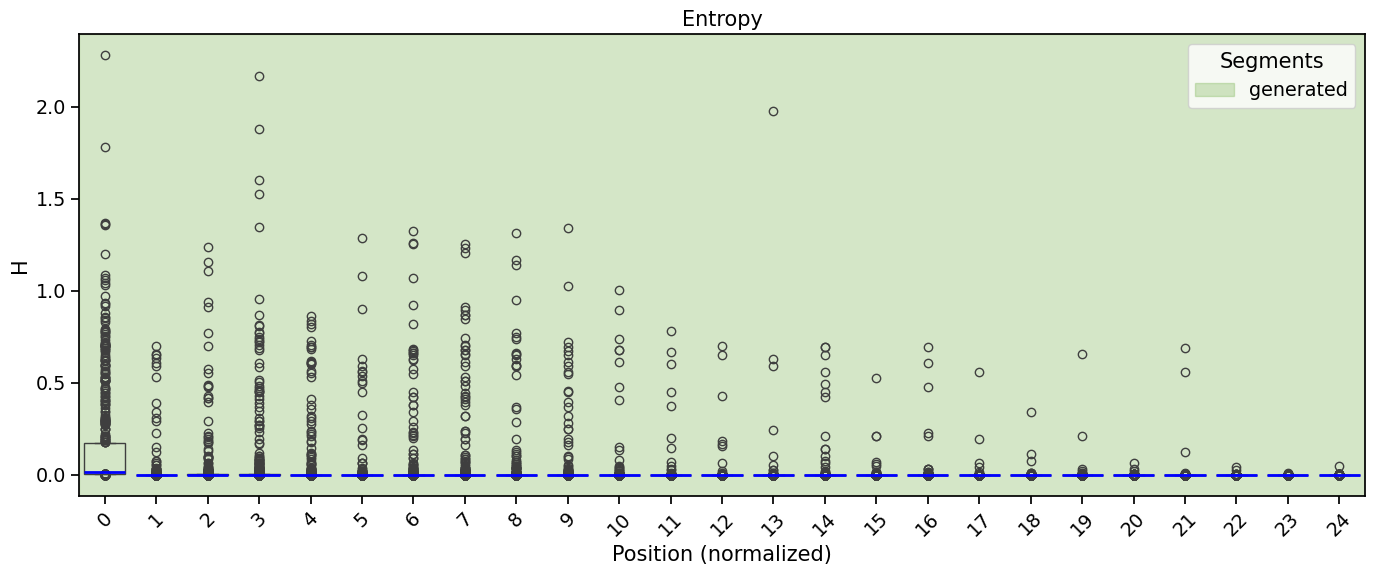

In [91]:
# only generated

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 25
m_ = m[ ((m.segment == 'generated') & (m.tokzero < delta))] #  

background_regions_ = [
    (0, delta, palette[4], 'generated'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=True,        
    showfliers=True,
    whis=[25, 75],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'blue', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [92]:
m.segment.unique()

array(['preamble', 'instruction', 'input', 'question', 'postilla',
       'generated'], dtype=object)

In [93]:
m[m.segment=='preamble'].groupby('pid').size().std()

0.0

In [94]:
m[m.segment=='instruction'].groupby('pid').size().std()

0.0

In [95]:
m[m.segment=='input'].groupby('pid').size().std()

669.9605099312157

In [96]:
m[m.tok_rel_segm_abs<1.].true_ent.var()

6.0150967

In [97]:
df[df.tok_bin_idx==0].true_ent.var()

10.178307

99


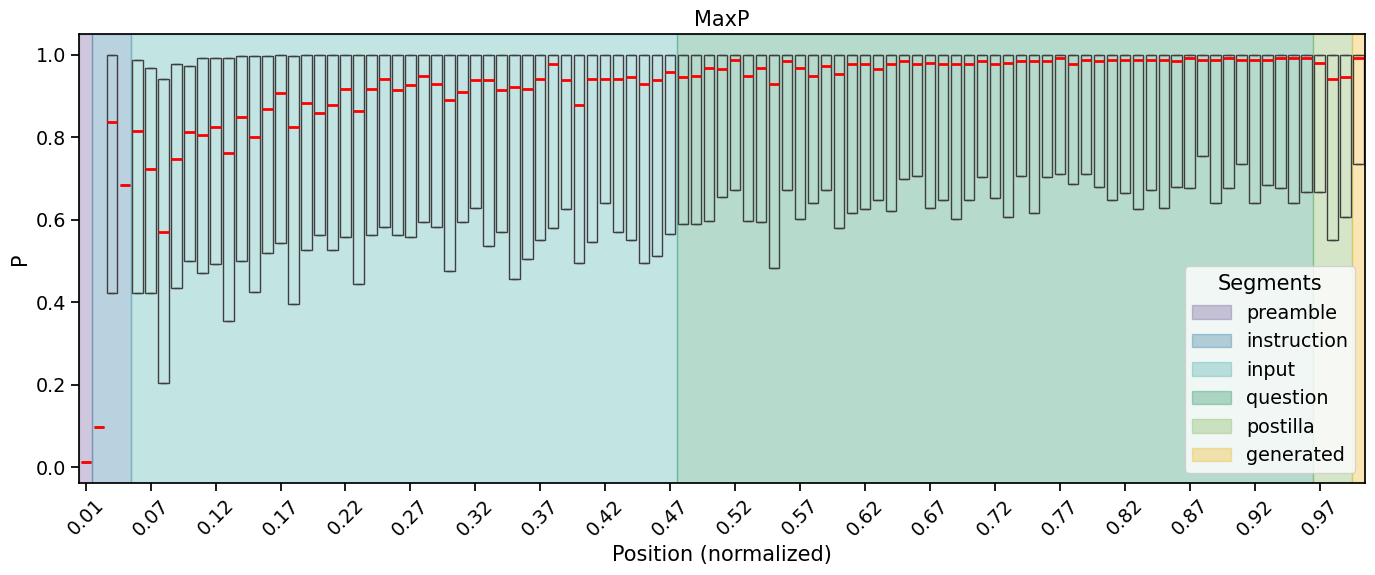

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m['tok_bin'] = pd.cut(m['tok_rel_segm'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))

patches = []
for start, end, color, label in background_regions:
    start_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > start ][0]
    end_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > end ]
    if not end_bin: end_bin = len(bin_mapping) - 1 
    else: end_bin = end_bin[0] - 1
    ax.axvspan(bin_mapping[bks[start_bin]]-0.5, bin_mapping[bks[end_bin]]+0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="maxp", 
    showcaps=True,        
    showfliers=False,
    whis=[25, 75],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("P")
plt.title("MaxP")

ax.legend(handles=patches, title="Segments", loc="lower right")

plt.tight_layout()

plt.show()

99


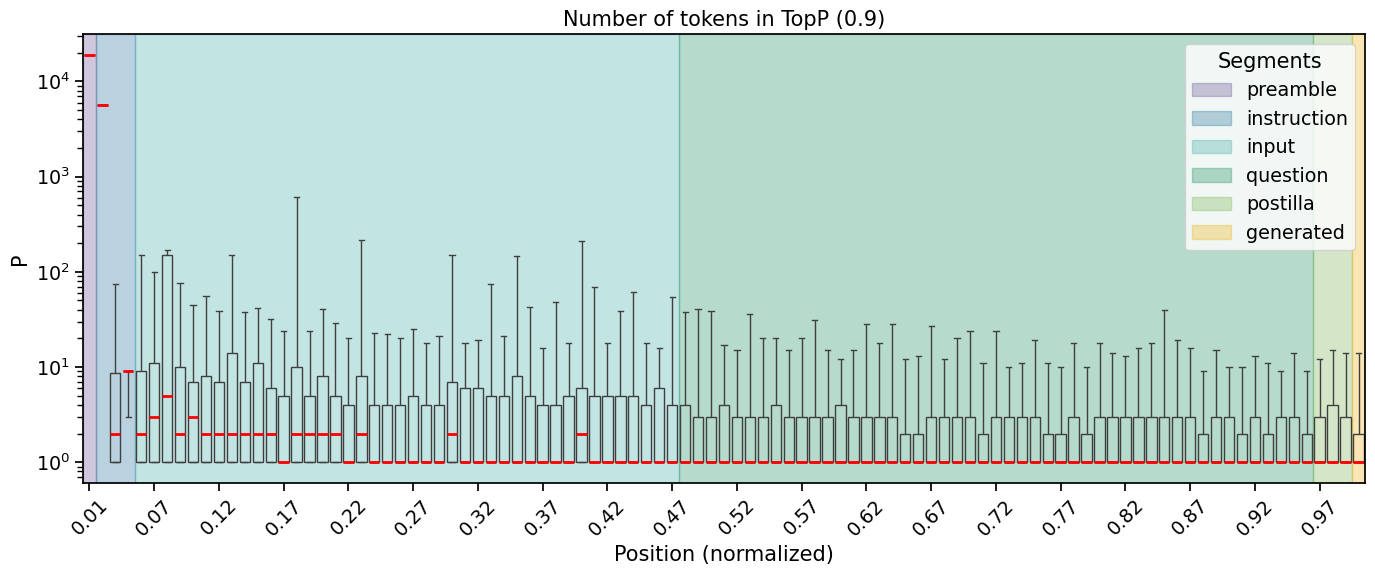

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m['tok_bin'] = pd.cut(m['tok_rel_segm'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))

patches = []
for start, end, color, label in background_regions:
    start_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > start ][0]
    end_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > end ]
    if not end_bin: end_bin = len(bin_mapping) - 1 
    else: end_bin = end_bin[0] - 1
    ax.axvspan(bin_mapping[bks[start_bin]]-0.5, bin_mapping[bks[end_bin]]+0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

# Sort for proper order
df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)  # Assign numerical index

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="shape", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

plt.yscale("log")

ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("P")
plt.title("Number of tokens in TopP (0.9)")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

## multiple runs

### check no variance in forward

In [100]:
mm[mm.area=='prompt'].true_ent.describe()

count    1.277830e+07
mean     8.333892e-01
std      1.237497e+00
min      1.428982e-10
25%      1.422500e-03
50%      1.912954e-01
75%      1.251900e+00
max      9.475863e+00
Name: true_ent, dtype: float64

In [101]:
mm

,run,pid,tok,area,shape,true_ent,maxp,trans_s,trans_l,logitlens_kl,logitlens_iou,start,end,segment,seq,length,tok_rel_segm,tok_rel_segm_abs,tokzero,tokzero_end
0,0,12,0,prompt,19111,9.367176e+00,0.012085,NaN,NaN,None,None,0,40,preamble,0,40,0.000000,0.000000,0,-41
6,0,12,1,prompt,5595,7.157337e+00,0.097656,NaN,NaN,None,None,0,40,preamble,0,40,0.025000,0.025000,1,-40
12,0,12,2,prompt,9,1.773033e+00,0.683594,NaN,NaN,None,None,0,40,preamble,0,40,0.050000,0.050000,2,-39
18,0,12,3,prompt,170,4.614149e+00,0.094727,NaN,NaN,None,None,0,40,preamble,0,40,0.075000,0.075000,3,-38
24,0,12,4,prompt,5,1.094237e+00,0.812500,NaN,NaN,None,None,0,40,preamble,0,40,0.100000,0.100000,4,-37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77457737,9,1794,2100,generated,1,2.291777e-07,1.000000,0.0,0.000000e+00,"[6.1875, 5.03125, 6.78125, 7.28125, 9.125, 8.1...","[7.544322897019993e-05, 8.134049129656744e-05,...",2081,2105,generated,5,24,0.997625,5.791667,19,-6
77457743,9,1794,2101,generated,1,6.453166e-07,1.000000,0.0,0.000000e+00,"[10.375, 8.75, 7.4374995, 7.3124995, 6.8749995...","[0.00011896264572924102, 9.63020030816641e-05,...",2081,2105,generated,5,24,0.998100,5.833333,20,-5
77457749,9,1794,2102,generated,1,3.022050e-06,1.000000,0.0,-1.192093e-07,"[0.65624845, 0.15722516, 0.69140464, 1.7187482...","[0.00016608536787908985, 0.0035714285714285713...",2081,2105,generated,5,24,0.998575,5.875000,21,-4
77457755,9,1794,2103,generated,1,1.198130e-06,1.000000,0.0,0.000000e+00,"[9.625, 8.9375, 8.6875, 8.25, 8.6875, 8.125, 8...","[8.995232526760817e-05, 0.00010240655401945725...",2081,2105,generated,5,24,0.999050,5.916667,22,-3


In [102]:
# variance before generate
mm[mm.area=='prompt'].groupby(['pid', 'tok'])['true_ent'].var().sum()

0.0

In [103]:
mm[mm.area=='prompt'].groupby(['pid', 'tok'])['shape'].var().sum()

0.0

In [104]:
mm[mm.area=='prompt'].groupby(['pid', 'tok'])['maxp'].var().sum()

0.0

In [105]:
# variance after generate
mm[mm.segment=='generated'].groupby(['pid', 'tok'])['true_ent'].var().sum()

14.473137

In [106]:
mm[mm.segment=='generated'].groupby(['pid', 'tok'])['shape'].var().sum()

63.59166666666667

In [107]:
mm[mm.segment=='generated'].groupby(['pid', 'tok'])['maxp'].var().sum()

2.407732436260301

### search prompts for which top-p varies

In [109]:
myvars = mm[mm.segment=='generated'].groupby(['pid', 'tok'])['maxp'].var()
variators = myvars[myvars>0.].to_frame().reset_index().pid.unique()

In [110]:
mv = mm[mm.pid.isin(variators)]

In [111]:
# prompts for which we observe an observable change over runs
v1 = mv.pid.unique()
v1

array([  12,   14,   17,   18,   23,   39,   41,   45,   53,   63,   74,
         94,  112,  118,  123,  125,  128,  130,  137,  138,  143,  164,
        181,  182,  188,  190,  194,  195,  209,  216,  218,  221,  224,
        229,  238,  265,  297,  305,  307,  318,  320,  352,  359,  367,
        368,  382,  398,  421,  446,  453,  457,  458,  474,  476,  484,
        486,  492,  493,  496,  507,  511,  521,  533,  558,  607,  613,
        621,  627,  629,  632,  633,  658,  667,  682,  698,  699,  700,
        708,  711,  731,  741,  757,  758,  768,  771,  782,  785,  790,
        805,  810,  823,  829,  839,  847,  854,  858,  864,  875,  879,
        880,  884,  886,  890,  902,  916,  918,  951,  952,  977,  984,
        992,  994, 1004, 1009, 1011, 1017, 1018, 1023, 1034, 1065, 1069,
       1070, 1071, 1073, 1077, 1088, 1094, 1098, 1099, 1104, 1113, 1123,
       1126, 1140, 1141, 1142, 1145, 1147, 1149, 1156, 1160, 1161, 1194,
       1203, 1204, 1208, 1210, 1212, 1228, 1235, 12

In [112]:
avg_truth = truth.groupby('pid').correct.mean().to_frame().reset_index()

In [113]:
# prompts for which we observe an output change over runs
v2 = avg_truth[avg_truth.correct<1.].pid.unique()
v2

array([  12,   14,   17,   18,   23,   41,   45,   53,   63,   74,   79,
         94,  118,  123,  125,  128,  130,  134,  137,  138,  139,  143,
        149,  164,  177,  181,  182,  188,  190,  194,  195,  200,  209,
        216,  218,  221,  224,  229,  238,  265,  297,  302,  307,  318,
        320,  352,  359,  364,  367,  368,  374,  382,  385,  398,  403,
        404,  421,  446,  453,  454,  457,  458,  474,  476,  484,  486,
        492,  493,  496,  507,  511,  521,  533,  558,  590,  607,  621,
        628,  629,  632,  633,  658,  682,  698,  699,  700,  708,  711,
        731,  741,  743,  757,  758,  768,  771,  777,  782,  785,  790,
        792,  805,  810,  823,  829,  830,  834,  839,  840,  847,  854,
        858,  864,  875,  879,  880,  884,  886,  902,  916,  918,  951,
        952,  961,  977,  984,  992,  994, 1009, 1011, 1017, 1018, 1023,
       1028, 1034, 1037, 1065, 1069, 1070, 1071, 1073, 1077, 1088, 1094,
       1097, 1098, 1099, 1123, 1126, 1140, 1141, 11

In [114]:
set(v1) - set(v2)

{39,
 112,
 305,
 613,
 627,
 667,
 890,
 1004,
 1104,
 1113,
 1210,
 1288,
 1331,
 1440,
 1548,
 1750}

In [115]:
# correctness over prompts for which observable changed over different runs
avg_truth[avg_truth.pid.isin(v1)]

,pid,correct
0,12,0.2
1,14,0.6
2,17,0.7
3,18,0.4
5,23,0.2
...,...,...
499,1726,0.3
502,1740,0.0
505,1750,1.0
507,1754,0.1


In [116]:
# ??? correctness over prompts for which observable did NOT change over different runs
avg_truth[(~avg_truth.pid.isin(v1)) & (avg_truth.correct<1.) & (avg_truth.correct>0.)]

,pid,correct


In [117]:
m_

,run,pid,tok,area,shape,true_ent,maxp,trans_s,trans_l,logitlens_kl,...,segment,seq,length,tok_rel_segm,tok_rel_segm_abs,tokzero,tokzero_end,tok_bin,tok_bin_hi,tok_bin_lo
12425,0,12,2070,generated,1,1.868550e-02,0.997728,0.0,-2.274666e-03,"[12.042888, 11.480716, 11.854022, 9.983017, 11...",...,generated,5,25,0.988067,5.000000,0,-26,"(4.965, 5.025]",5.025,4.965
12431,0,12,2071,generated,1,5.970278e-07,1.000000,0.0,0.000000e+00,"[11.75, 12.25, 12.625, 12.3125, 13.0625, 12.68...",...,generated,5,25,0.988544,5.040000,1,-25,"(5.025, 5.085]",5.085,5.025
12437,0,12,2072,generated,1,1.343955e-05,0.999999,0.0,-8.344647e-07,"[12.624991, 10.37499, 11.312491, 11.062491, 11...",...,generated,5,25,0.989021,5.080000,2,-24,"(5.025, 5.085]",5.085,5.025
12443,0,12,2073,generated,1,1.297240e-05,0.999999,0.0,-7.152555e-07,"[11.312488, 11.187489, 10.812489, 10.187489, 9...",...,generated,5,25,0.989499,5.120000,3,-23,"(5.085, 5.145]",5.145,5.085
12449,0,12,2074,generated,1,2.898873e-02,0.996175,0.0,-3.835941e-03,"[15.0222025, 14.710552, 12.157436, 10.976287, ...",...,generated,5,25,0.989976,5.160000,4,-22,"(5.145, 5.204]",5.204,5.145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77344067,0,1794,2100,generated,1,2.291777e-07,1.000000,0.0,0.000000e+00,"[6.1875, 5.03125, 6.78125, 7.28125, 9.125, 8.1...",...,generated,5,24,0.997625,5.791667,19,-6,"(5.743, 5.803]",5.803,5.743
77344073,0,1794,2101,generated,1,6.453166e-07,1.000000,0.0,0.000000e+00,"[10.375, 8.75, 7.4374995, 7.3124995, 6.8749995...",...,generated,5,24,0.998100,5.833333,20,-5,"(5.803, 5.862]",5.862,5.803
77344079,0,1794,2102,generated,1,3.022050e-06,1.000000,0.0,-1.192093e-07,"[0.65624845, 0.15722516, 0.69140464, 1.7187482...",...,generated,5,24,0.998575,5.875000,21,-4,"(5.862, 5.922]",5.922,5.862
77344085,0,1794,2103,generated,1,1.198130e-06,1.000000,0.0,0.000000e+00,"[9.625, 8.9375, 8.6875, 8.25, 8.6875, 8.125, 8...",...,generated,5,24,0.999050,5.916667,22,-3,"(5.862, 5.922]",5.922,5.862


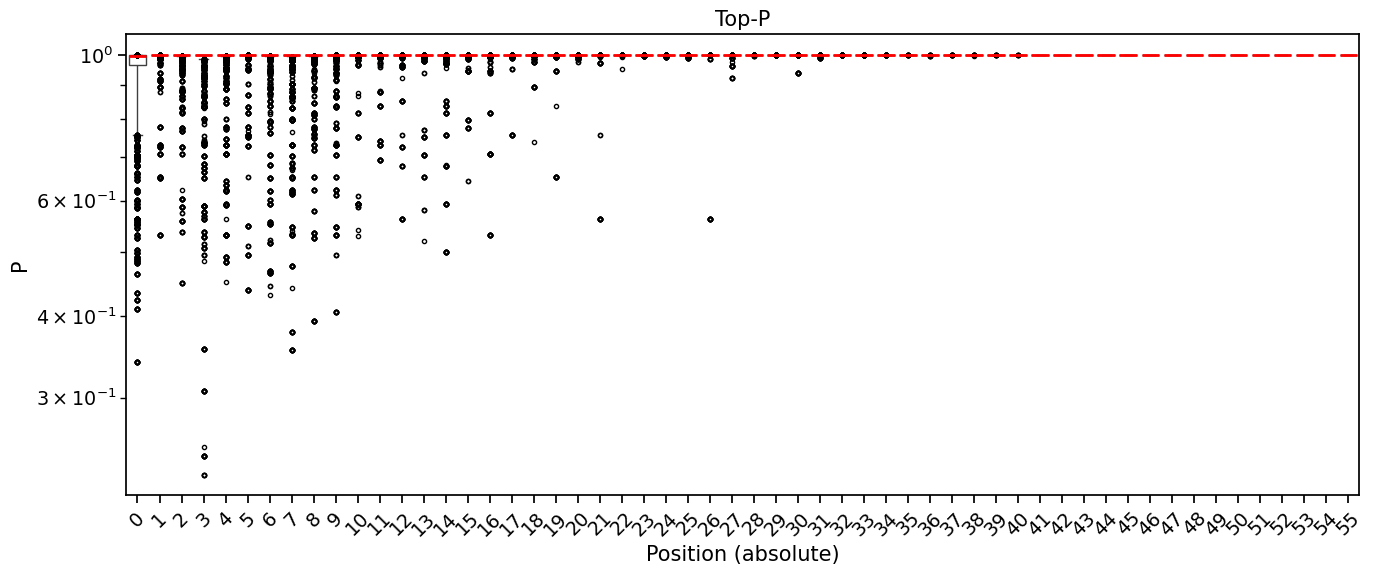

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()
m_['tokzero'] = m_['tok'] - m_['start']
 
sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="maxp", 
    # hue='pid',
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    flierprops = dict(marker='o', markerfacecolor='None', markersize=3,  markeredgecolor='black'),
    ax = ax
)

plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (absolute)")
plt.ylabel("P")
plt.title("Top-P")


plt.tight_layout()

plt.show()

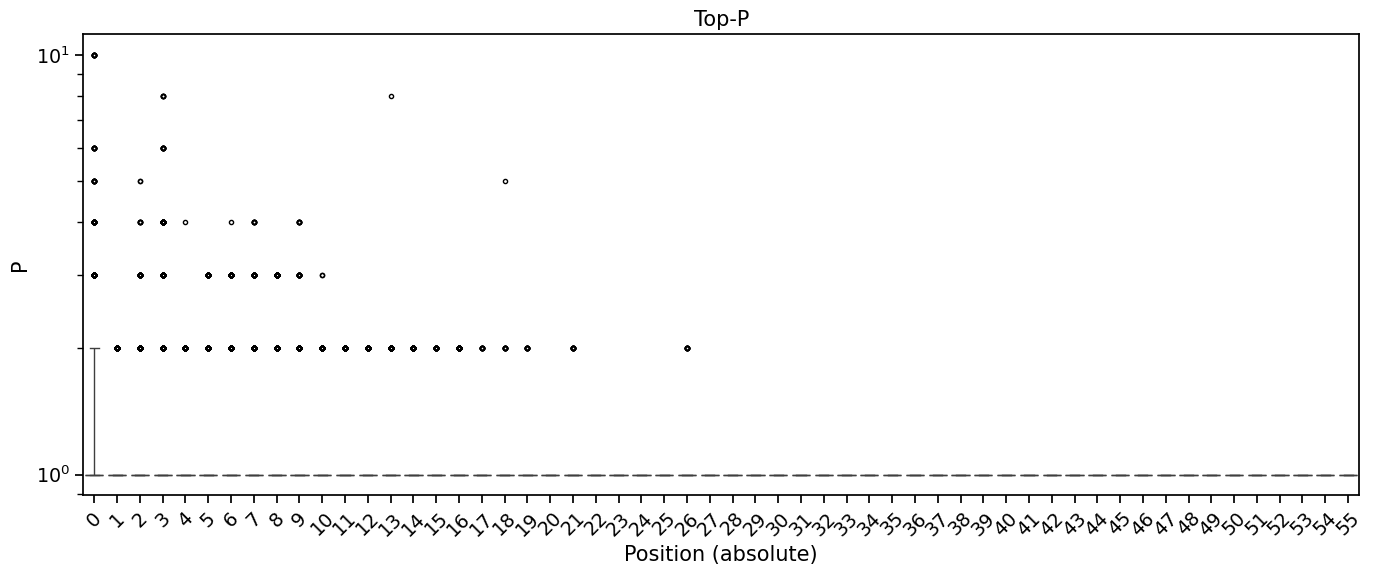

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()

m_['tokzero'] = m_['tok'] - m_['start']

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="shape", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    flierprops = dict(marker='o', markerfacecolor='None', markersize=3,  markeredgecolor='black'),
    ax = ax
)

plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (absolute)")
plt.ylabel("P")
plt.title("Top-P")


plt.tight_layout()

plt.show()

In [120]:
m_

,run,pid,tok,area,shape,true_ent,maxp,trans_s,trans_l,logitlens_kl,logitlens_iou,start,end,segment,seq,length,tok_rel_segm,tok_rel_segm_abs,tokzero,tokzero_end
12425,0,12,2070,generated,1,1.868550e-02,0.997728,0.0,-2.274666e-03,"[12.042888, 11.480716, 11.854022, 9.983017, 11...","[0.0, 0.0, 0.0, 7.330303474563847e-05, 7.02148...",2070,2095,generated,5,25,0.988067,5.000000,0,-26
12431,0,12,2071,generated,1,5.970278e-07,1.000000,0.0,0.000000e+00,"[11.75, 12.25, 12.625, 12.3125, 13.0625, 12.68...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.156...",2070,2095,generated,5,25,0.988544,5.040000,1,-25
12437,0,12,2072,generated,1,1.343955e-05,0.999999,0.0,-8.344647e-07,"[12.624991, 10.37499, 11.312491, 11.062491, 11...","[0.0, 8.811349017534584e-05, 0.0, 9.1207588471...",2070,2095,generated,5,25,0.989021,5.080000,2,-24
12443,0,12,2073,generated,1,1.297240e-05,0.999999,0.0,-7.152555e-07,"[11.312488, 11.187489, 10.812489, 10.187489, 9...","[0.0, 0.0, 0.00013422818791946307, 0.000130480...",2070,2095,generated,5,25,0.989499,5.120000,3,-23
12449,0,12,2074,generated,1,2.898873e-02,0.996175,0.0,-3.835941e-03,"[15.0222025, 14.710552, 12.157436, 10.976287, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0001133658315...",2070,2095,generated,5,25,0.989976,5.160000,4,-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77457737,9,1794,2100,generated,1,2.291777e-07,1.000000,0.0,0.000000e+00,"[6.1875, 5.03125, 6.78125, 7.28125, 9.125, 8.1...","[7.544322897019993e-05, 8.134049129656744e-05,...",2081,2105,generated,5,24,0.997625,5.791667,19,-6
77457743,9,1794,2101,generated,1,6.453166e-07,1.000000,0.0,0.000000e+00,"[10.375, 8.75, 7.4374995, 7.3124995, 6.8749995...","[0.00011896264572924102, 9.63020030816641e-05,...",2081,2105,generated,5,24,0.998100,5.833333,20,-5
77457749,9,1794,2102,generated,1,3.022050e-06,1.000000,0.0,-1.192093e-07,"[0.65624845, 0.15722516, 0.69140464, 1.7187482...","[0.00016608536787908985, 0.0035714285714285713...",2081,2105,generated,5,24,0.998575,5.875000,21,-4
77457755,9,1794,2103,generated,1,1.198130e-06,1.000000,0.0,0.000000e+00,"[9.625, 8.9375, 8.6875, 8.25, 8.6875, 8.125, 8...","[8.995232526760817e-05, 0.00010240655401945725...",2081,2105,generated,5,24,0.999050,5.916667,22,-3


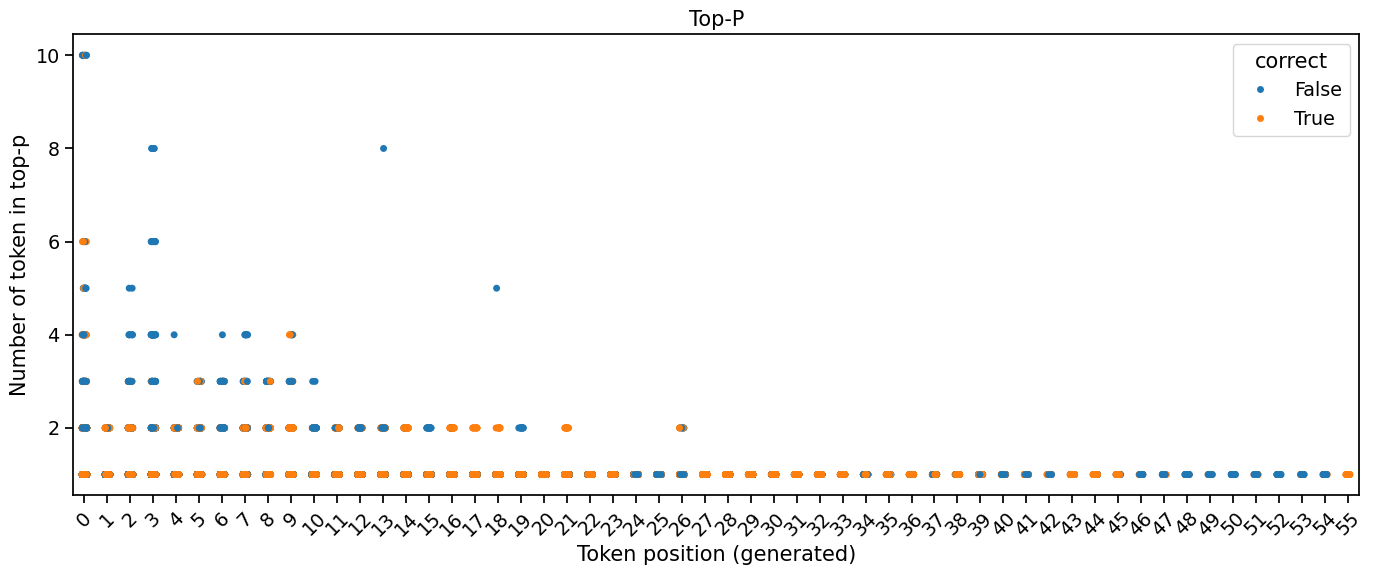

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()


m_ = m_.merge(truth, on=['run', 'pid'])

sns.stripplot(
    data=m_, 
    x="tokzero", 
    y="shape", 
    hue='correct',
    ax = ax
)

# plt.yscale("log")

plt.xticks(rotation=45)

plt.ylabel("Number of token in top-p")
plt.xlabel("Token position (generated)")
plt.title("Top-P")


plt.tight_layout()

plt.show()

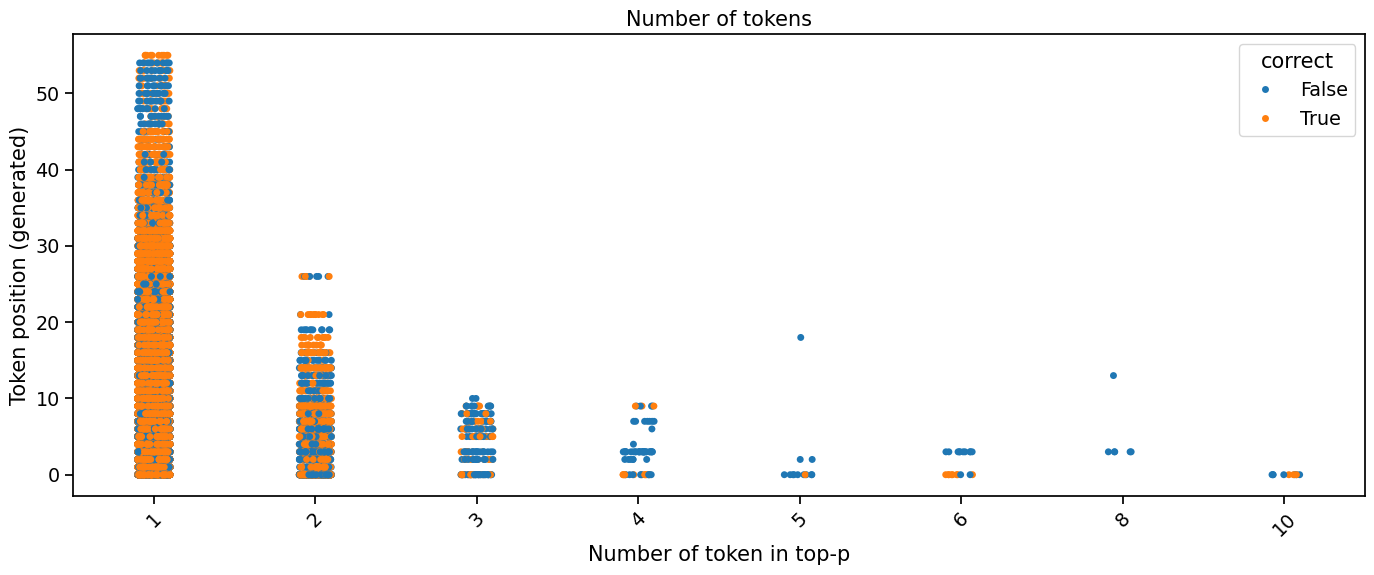

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()


m_ = m_.merge(truth, on=['run', 'pid'])

sns.stripplot(
    data=m_, 
    y="tokzero", 
    x="shape", 
    hue='correct',
    ax = ax
)

# plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Number of token in top-p")
plt.ylabel("Token position (generated)")
plt.title("Number of tokens")


plt.tight_layout()

plt.show()

In [123]:
m_.groupby('shape').correct.agg(['count', 'mean'])

,count,mean
shape,,
1,123339,0.722545
2,2519,0.541485
3,228,0.324561
4,72,0.194444
5,13,0.076923
6,20,0.400000
8,6,0.000000
10,10,0.300000


In [124]:
# 2%
m_.groupby('shape').correct.count() / m_.groupby('shape').correct.count().sum()

shape
1     0.977275
2     0.019959
3     0.001807
4     0.000570
5     0.000103
6     0.000158
8     0.000048
10    0.000079
Name: correct, dtype: float64

In [125]:
mm[mm.segment=='generated'].true_ent.describe()

count    1.262070e+05
mean     2.005983e-02
std      1.138203e-01
min      6.555112e-12
25%      4.188464e-07
50%      4.375451e-06
75%      8.189415e-05
max      2.279310e+00
Name: true_ent, dtype: float64

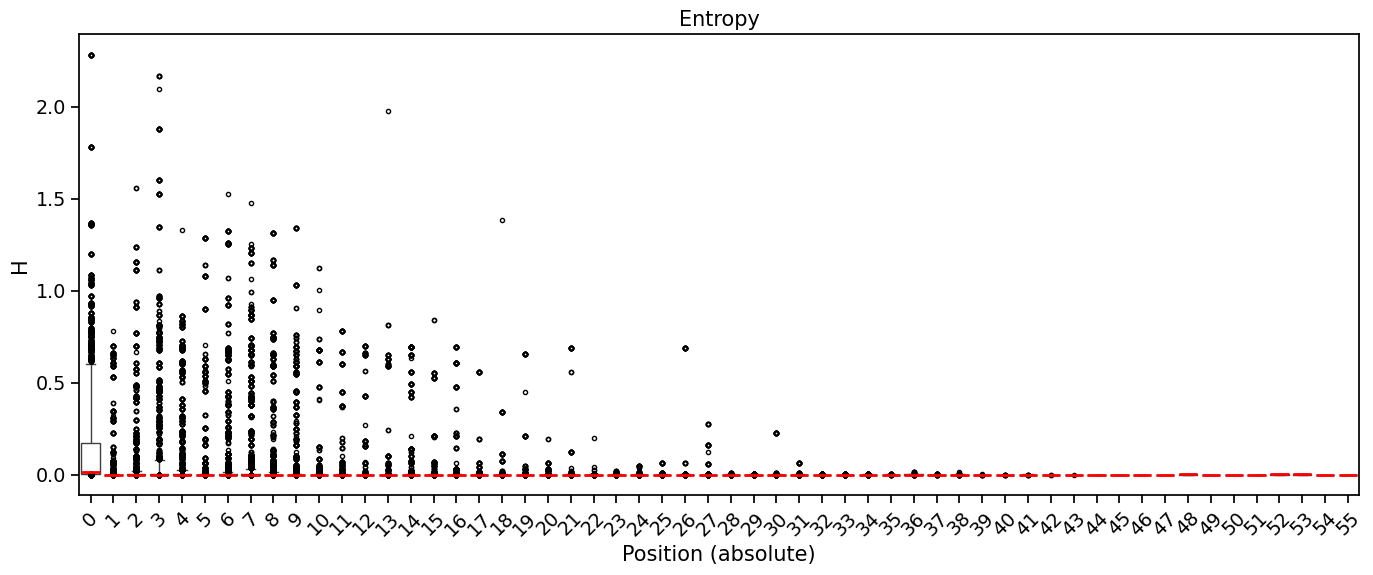

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()
 
sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    # hue='pid',
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    flierprops = dict(marker='o', markerfacecolor='None', markersize=3,  markeredgecolor='black'),
    ax = ax
)

# plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (absolute)")
plt.ylabel("H")
plt.title("Entropy")


plt.tight_layout()

plt.show()

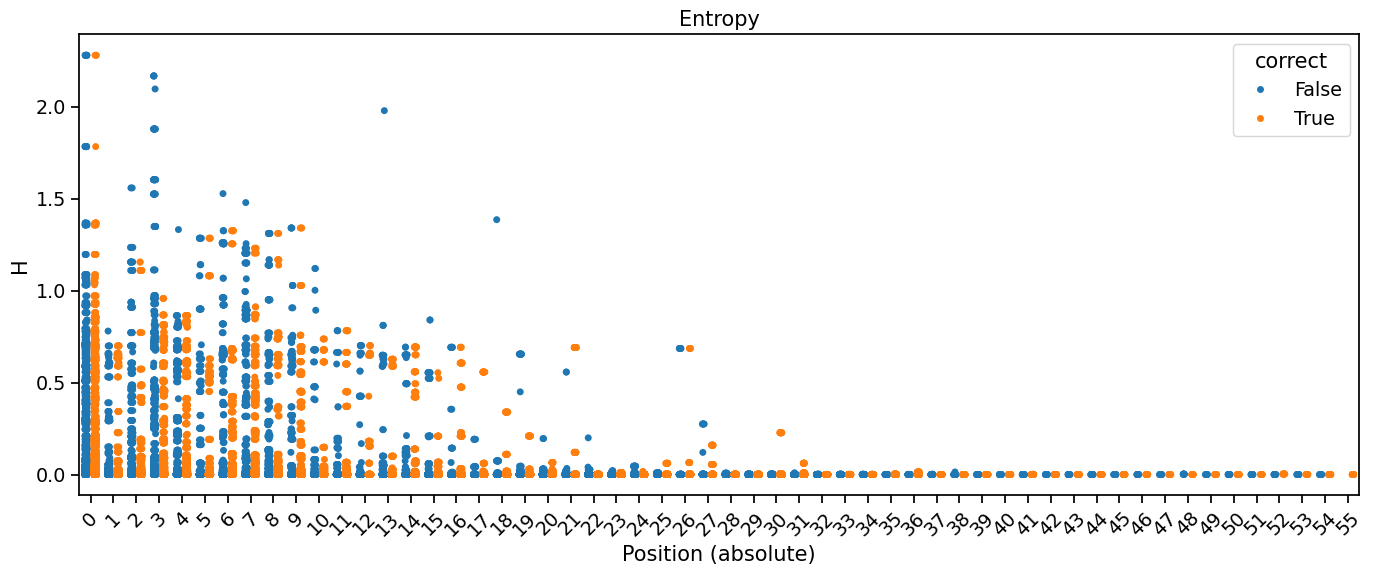

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()

m_ = mm[mm.segment=='generated'].copy()

m_ = m_.merge(truth, on=['run', 'pid'])

sns.stripplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    hue='correct',
    dodge=True,
    size=5,
    ax = ax
)


plt.xticks(rotation=45)

plt.xlabel("Position (absolute)")
plt.ylabel("H")
plt.title("Entropy")


plt.tight_layout()

plt.show()

In [128]:
mm[(mm.segment=='generated') & (mm.pid==1)]

,run,pid,tok,area,shape,true_ent,maxp,trans_s,trans_l,logitlens_kl,logitlens_iou,start,end,segment,seq,length,tok_rel_segm,tok_rel_segm_abs,tokzero,tokzero_end


In [129]:
mm[(mm.segment=='generated') & (mm.pid==2)]

,run,pid,tok,area,shape,true_ent,maxp,trans_s,trans_l,logitlens_kl,logitlens_iou,start,end,segment,seq,length,tok_rel_segm,tok_rel_segm_abs,tokzero,tokzero_end


In [130]:
mm.shape

(12909627, 20)

In [131]:
m.shape

(1290959, 23)

In [132]:
# TODO: compare variance in generate (same prompt / multiple prompts)

In [133]:
# TODO: compare observables grouping by truth

In [134]:
# TODO: plot truth vs aggregated uncertainty